In [17]:
import numpy as np
from scipy.io.wavfile import read
import re
import os
import MFCC
import gmmhmm
from sklearn.model_selection import train_test_split
import pickle as pkl

# Speech recognition using Continuous Density Hidden Markov Models (CDHMM)

## GMMHMM (Gaussian Mixture Model HMM)

Below is a function which accepts a GMMHMM as well as an integer `n_sim`, and which simulates the GMMHMM process, generating `n_sim` different observations.

In [8]:
def sample_gmmhmm(gmmhmm, n_sim, K=3):
    """
    Simulate sampling from a GMMHMM.

    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, K)
        The generated observations (column vectors of length K)
    """
    A, weights, means, covars, pi = tuple(gmmhmm)
    states = [np.random.choice(np.arange(len(pi)), p=pi)]
    sample_component = np.argmax(np.random.multinomial(1, weights[states[-1],:]))
    sample = np.random.multivariate_normal(means[states[-1], sample_component, :], covars[states[-1], sample_component, :, :])
    obs = [sample]
    last_component = 0
    for _ in range(n_sim):
        states.append(np.random.choice(np.arange(len(pi)), p=A[states[-1]]))
        sample_component = np.argmax(np.random.multinomial(1, weights[states[-1],:]))
        sample = np.random.multivariate_normal(means[states[-1], sample_component, :], covars[states[-1], sample_component, :, :])
        obs.append(sample)
    
    return np.array(states), np.array(obs)

## Voice recordings, spectrograms, and MFCC

We use dozens of recordings for each of the words/phrases mathematics, biology,
political science, psychology, and statistics. These audio samples are 2 seconds in
duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed
integers in WAV format. We load the recordings into Python using scipy.io.wavfile.read.

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


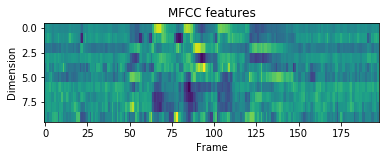

In [12]:
# bio_mfcc, math_mfcc, polisci_mfcc, psych_mfcc, stats_mfcc = [],[],[],[],[]
all_mfcc = [[],[],[],[],[]]
for list_idx, name_base in enumerate(["Biology","Mathematics","PoliticalScience", "Psychology", "Statistics"]):
    for i in range(31):
        filename = "Samples/" + name_base + " (" + str(i) + ").wav"
        sample = read(filename)
        mfccs = MFCC.extract(sample[1])
        all_mfcc[list_idx].append(mfccs)

## HMM model training on MFCC data

We partition each list of MFCCs into a training set of 20 samples, and a test set of
the remaining 10 samples.

Using the training sets, we train a GMMHMM on each of the words from the previous problem
with at least 10 random restarts, keeping the best model for each word (the one with the highest
log-likelihood). 

This process may take several minutes. Since you will not want to run this
more than once, you will want to save the best model for each word to disk using the pickle
module so that you can use it later.

In [18]:
def initialize(n):
    """
    takes in number of states and creates random 
    initial state distribution and transition matrix
    
    inputs:
        n: number of states
        
    outputs:
        startprob: initial state distribution
        transmat: transition matrix
    """
    # create initial state distribution
    startprob = np.random.rand(n)
    startprob /= np.sum(startprob)
    
    # create transition matrix
    transmat = np.random.rand(n,n)
    transmat = (transmat.T/np.sum(transmat, axis=1)).T
    
    # return results
    return startprob, transmat

In [19]:
save_test_samps = {}
for list_idx, name_base in enumerate(["Biology","Mathematics","PoliticalScience", "Psychology", "Statistics"]):
    print(name_base,end=' ',flush=True)
    samples = all_mfcc[list_idx]
    # test train split
    train_samps, test_samps = tuple( train_test_split(samples,test_size=10) )
    # save test samps
    save_test_samps[name_base] = test_samps 
    # then find the best model!
    best_prob = -np.inf
    best_model = None
    for _ in range(10):
        print(_,end=' ',flush=True)
        startprob, transmat = initialize(5)
        model = gmmhmm.GMMHMM(n_components=5, n_mix=3, transmat=transmat, startprob=startprob, cvtype='diag')
        model.covars_prior = 0.01
        model.fit(train_samps, init_params='mc', var=0.1)
        if model.logprob > best_prob:
            best_model = model
    print("",flush=True)
    print("Opening pickle file...",flush=True)
    # save to pkl
    with open(name_base+".pkl",'wb') as f:
        pkl.dump(best_model, f)

Biology 0 1 2 3 4 5 6 7 8 9 
Opening pickle file...
Mathematics 0 1 2 3 4 5 6 7 8 9 
Opening pickle file...
PoliticalScience 0 1 2 3 4 5 6 7 8 9 
Opening pickle file...
Psychology 0 1 2 3 4 5 6 7 8 9 
Opening pickle file...
Statistics 0 1 2 3 4 5 6 7 8 9 
Opening pickle file...


## Evaluate performance and testing data

Classify the 10 test samples for each word. How does your system perform?
Which words are the hardest to correctly classify? 

Below we show a dictionary containing the accuracy
of the classification of your five testing sets. Specifically, the words/phrases are the keys,
and the values are the percent accuracy.

In [21]:
word_to_accuracy = {}
models = []
for list_idx, name_base in enumerate(["Biology","Mathematics","PoliticalScience", "Psychology", "Statistics"]):
    # Calculate accuracy
    print("Getting "+name_base+" pickle",flush=True)
    with open(name_base+".pkl",'rb') as f:
        models.append(pkl.load(f))
        
for list_idx, name_base in enumerate(["Biology","Mathematics","PoliticalScience", "Psychology", "Statistics"]):
    print("Finding "+name_base+" scores", end=' ', flush=True)
    tot_scores = 0
    for obs in save_test_samps[name_base]:
        print(".",end=' ',flush=True)
        predicted_list_idx = np.argmax([mod.score(obs) for mod in models])
        if predicted_list_idx == list_idx:
            tot_scores += 1
    avg_score = tot_scores/10.
    word_to_accuracy[name_base] = 100*avg_score
    print("",flush=True)

Getting Biology pickle
Getting Mathematics pickle
Getting PoliticalScience pickle
Getting Psychology pickle
Getting Statistics pickle
Finding Biology scores . . . . . . . . . . 
Finding Mathematics scores . . . . . . . . . . 
Finding PoliticalScience scores . . . . . . . . . . 
Finding Psychology scores . . . . . . . . . . 
Finding Statistics scores . . . . . . . . . . 


In [22]:
word_to_accuracy

{'Biology': 100.0,
 'Mathematics': 100.0,
 'PoliticalScience': 90.0,
 'Psychology': 100.0,
 'Statistics': 100.0}

These are very positive results! PoliSci had the worst results but still pretty dang good :)